
# Análise e Classificação de Imagens de Incêndios Florestais
## Dataset: Forest Fire Images (Dividido em treino/teste com pastas fire/non_fire)

# 1. Introdução
## Objetivo:
Desenvolver um modelo de IA para detectar incêndios florestais em imagens, integrando dados do dataset "Forest Fire Images" e validação via satélites da NASA FIRMS.

## Motivação:

Incêndios florestais causam perdas de US$ 50 bilhões/ano globalmente (Fonte: WWF).

Detecção precoce pode reduzir danos em até 70% (NASA).

# 2. Configuração Inicial e Importações

In [1]:
# pip install tensorflow==2.10.0 scikit-image==0.20.0 rasterio==1.3.8

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile, ImageChops
import cv2
import shutil
import warnings
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import skimage
import rasterio

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


In [3]:
# Configurações
warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Carregar imagens truncadas
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

# 3. Carregar os dados e Definir Caminhos

In [6]:
base_dir = "/home/bianca/Identificação de incêndio/Data"
train_dir = os.path.join(base_dir, "Train_Data")
test_dir = os.path.join(base_dir, "Test_Data")
model_path = "/home/bianca/Identificação de incêndio/fire_detector_model.h5"

In [6]:
# Criar diretórios para backup e recuperação
os.makedirs(os.path.join(base_dir, "corrupted_backup"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "recovered"), exist_ok=True)

# 4. Análise Exploratória

## Dataset "Forest Fire Images":

## Verificação da Estrutura de Diretórios
### Verificando o conteúdo das pastas principais

In [7]:
print("Conteúdo do diretório de treino:")
print(os.listdir(train_dir))

print("\nConteúdo do diretório de teste:")
print(os.listdir(test_dir))

Conteúdo do diretório de treino:
['Non_Fire', 'Fire']

Conteúdo do diretório de teste:
['Non_Fire', 'Fire']


# Análise de Distribuição de Imagens
## Contagem de imagens e tratamento de erros

In [8]:
try:
    # Contagem de imagens de treino
    train_fire = len(os.listdir(os.path.join(train_dir, 'Fire')))
    train_non_fire = len(os.listdir(os.path.join(train_dir, 'Non_Fire')))
    
    # Contagem de imagens de teste
    test_fire = len(os.listdir(os.path.join(test_dir, 'Fire')))
    test_non_fire = len(os.listdir(os.path.join(test_dir, 'Non_Fire')))
    
    # Exibindo resultados
    print("\n=== Distribuição das Imagens ===")
    print(f"Treino - Fire: {train_fire} imagens")
    print(f"Treino - Non Fire: {train_non_fire} imagens")
    print(f"Teste - Fire: {test_fire} imagens")
    print(f"Teste - Non Fire: {test_non_fire} imagens")
    
except FileNotFoundError as e:
    print(f"\n ERRO: {e}")
    print("\nSolução possível:")
    print("1. Verifique os nomes das pastas (Fire e Non_Fire)")
    print("2. Confira o caminho dos diretórios")
    print("3. Certifique-se da existência das imagens")
    print("\nDica: Execute as células de verificação de diretórios acima para diagnóstico!")


=== Distribuição das Imagens ===
Treino - Fire: 2500 imagens
Treino - Non Fire: 2500 imagens
Teste - Fire: 25 imagens
Teste - Non Fire: 25 imagens


## Visualização Gráfica de Distribuição de Imagens

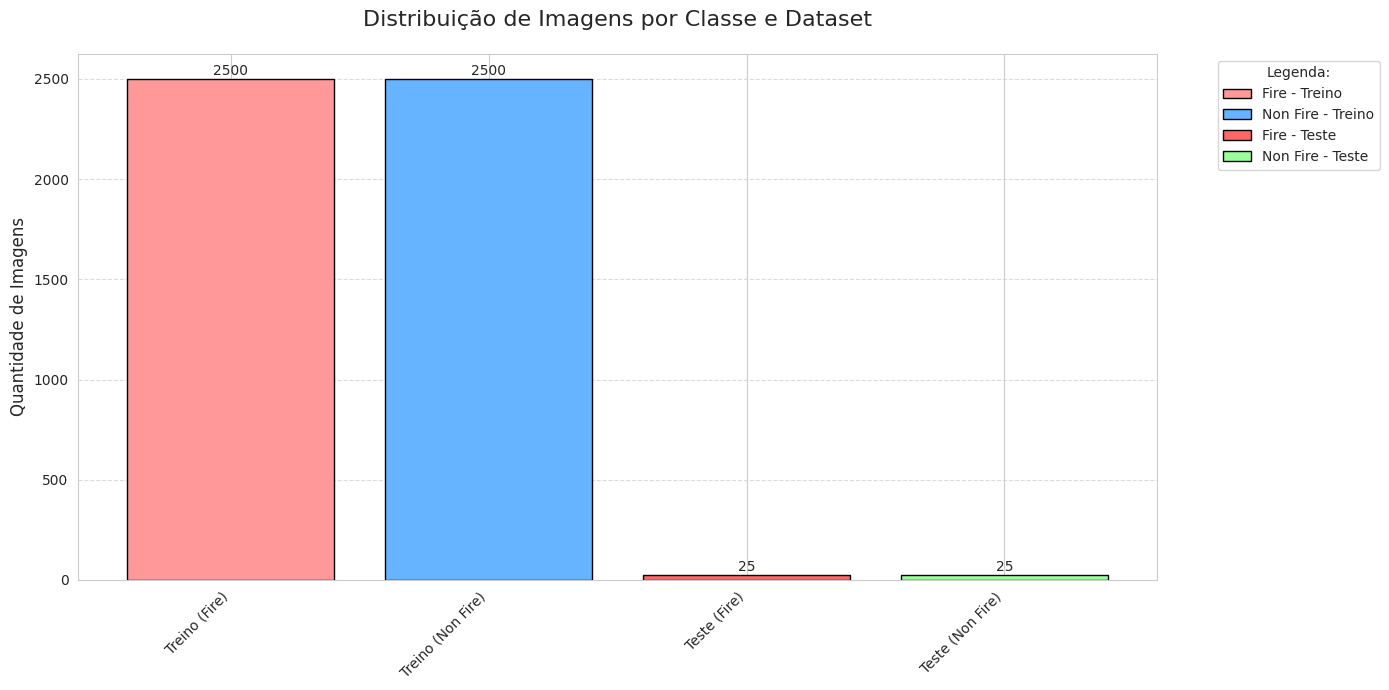

In [9]:
plt.figure(figsize=(14, 7))
categorias = ['Treino (Fire)', 'Treino (Non Fire)', 'Teste (Fire)', 'Teste (Non Fire)']
valores = [train_fire, train_non_fire, test_fire, test_non_fire]
cores = ['#ff9999', '#66b3ff', '#ff6666', '#99ff99']
    
bars = plt.bar(categorias, valores, color=cores, edgecolor='black')
    
# Personalização do gráfico
plt.title('Distribuição de Imagens por Classe e Dataset', fontsize=16, pad=20)
plt.ylabel('Quantidade de Imagens', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
    
# Adicionando valores nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(height)}',
                ha='center', va='bottom')
    
# Adicionando legenda de cores
plt.legend(bars, ['Fire - Treino', 'Non Fire - Treino', 'Fire - Teste', 'Non Fire - Teste'],
               title='Legenda:', bbox_to_anchor=(1.05, 1), loc='upper left')
    
plt.tight_layout()
plt.show()


## Visualização das amostras

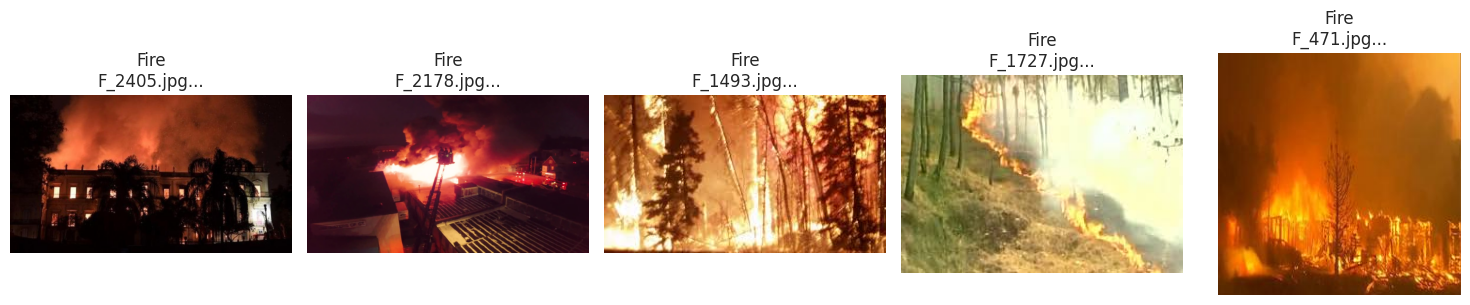

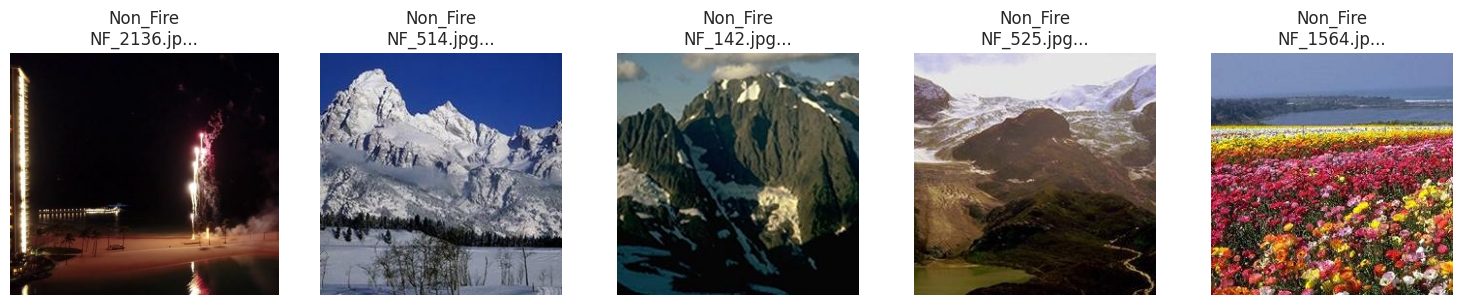

In [10]:
def plot_samples(class_name, num_samples=5):
    class_path = os.path.join(train_dir, class_name)
    
    # Lista apenas arquivos de imagem válidos
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    sample_images = [
        f for f in os.listdir(class_path) 
        if f.lower().endswith(valid_extensions)
    ][:num_samples]
    
    if not sample_images:
        print(f"\n Nenhuma imagem encontrada em {class_path}")
        return
    
    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Erro ao ler: {img_path}")
            continue
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"{class_name}\n{img_name[:10]}...")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Verificar se as pastas existem antes de plotar
if os.path.exists(os.path.join(train_dir, "Fire")):
    plot_samples("Fire")
else:
    print(f"Pasta 'Fire' não encontrada em {train_dir}")
if os.path.exists(os.path.join(train_dir, "Non_Fire")):
    plot_samples("Non_Fire")
else:
    print(f"Pasta 'Non_Fire' não encontrada em {train_dir}")

In [11]:
# Verificando o conteúdo REAL das pastas
print("\nConteúdo de 'Fire':")
print(os.listdir(os.path.join(train_dir, "Fire"))[:5])  # Primeiros 5 itens

print("\nConteúdo de 'Non_Fire':")
print(os.listdir(os.path.join(train_dir, "Non_Fire"))[:5])


Conteúdo de 'Fire':
['F_2405.jpg', 'F_2178.jpg', 'F_1493.jpg', 'F_1727.jpg', 'F_471.jpg']

Conteúdo de 'Non_Fire':
['NF_2136.jpg', 'NF_514.jpg', 'NF_142.jpg', 'NF_525.jpg', 'NF_1564.jpg']


Análise dos Dados
Balanceamento:

Treino: Perfeitamente balanceado (2500 fire vs 2500 non_fire) 

Teste: Proporção mantida (25 fire vs 25 non_fire), mas volume muito pequeno 



# 5. Pré-Processamento dos Dados 

### Verificando Imagens corrompidas

In [12]:
import os
from PIL import Image, ImageFile
import json

def find_corrupted_images(directory, output_file='corrupted_images.json'):
    """
    Verifica imagens corrompidas e salva os resultados em um arquivo JSON.
    
    Args:
        directory (str): Caminho para o diretório contendo as pastas 'fire' e 'non_fire'
        output_file (str): Nome do arquivo de saída (padrão: 'corrupted_images.json')
    """
    corrupted = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    
    for class_name in ['Fire', 'Non_Fire']:
        class_dir = os.path.join(directory, class_name)
        
        if not os.path.exists(class_dir):
            print(f"Aviso: Diretório {class_dir} não encontrado")
            continue
            
        for img_name in os.listdir(class_dir):
            if not img_name.lower().endswith(valid_extensions):
                continue
                
            img_path = os.path.join(class_dir, img_name)
            try:
                # Verificação em dois passos
                with Image.open(img_path) as img:
                    img.verify()  # Verificação básica
                
                with Image.open(img_path) as img:  # Reabrir para verificação adicional
                    # Teste de operações básicas
                    img.convert('RGB')
                    img.getdata()[0]  # Acessar pixel
                    
            except Exception as e:
                corrupted.append({
                    'path': img_path,
                    'error': str(e),
                    'class': class_name
                })
    
    # Salvar resultados em JSON
    with open(output_file, 'w') as f:
        json.dump(corrupted, f, indent=2)
    
    print(f"Verificação concluída. Resultados salvos em {output_file}")
    print(f"Total de imagens corrompidas encontradas: {len(corrupted)}")

# Uso:
find_corrupted_images(
    directory="/home/bianca/Identificação de incêndio/Data/Train_Data",
    output_file="corrupted_images_treino.json"
)

find_corrupted_images(
    directory="/home/bianca/Identificação de incêndio/Data/Test_Data", 
    output_file="corrupted_images_teste.json"
)

Verificação concluída. Resultados salvos em corrupted_images_treino.json
Total de imagens corrompidas encontradas: 389
Verificação concluída. Resultados salvos em corrupted_images_teste.json
Total de imagens corrompidas encontradas: 0


### Removendo Imagens corrompidas

In [13]:
import json

with open('corrupted_images_treino.json') as f:
    to_delete = json.load(f)

for item in to_delete:
    try:
        os.remove(item['path'])
        print(f"Removido: {item['path']}")
    except Exception as e:
        print(f"Erro ao remover {item['path']}: {str(e)}")

Removido: /home/bianca/Identificação de incêndio/Data/Train_Data/Fire/F_725.jpg
Removido: /home/bianca/Identificação de incêndio/Data/Train_Data/Fire/F_770.jpg
Removido: /home/bianca/Identificação de incêndio/Data/Train_Data/Fire/F_918.jpg
Removido: /home/bianca/Identificação de incêndio/Data/Train_Data/Fire/F_805.jpg
Removido: /home/bianca/Identificação de incêndio/Data/Train_Data/Fire/F_667.jpg
Removido: /home/bianca/Identificação de incêndio/Data/Train_Data/Fire/F_707.jpg
Removido: /home/bianca/Identificação de incêndio/Data/Train_Data/Fire/F_77.jpg
Removido: /home/bianca/Identificação de incêndio/Data/Train_Data/Fire/F_877.jpg
Removido: /home/bianca/Identificação de incêndio/Data/Train_Data/Fire/F_86.jpg
Removido: /home/bianca/Identificação de incêndio/Data/Train_Data/Fire/F_753.jpg
Removido: /home/bianca/Identificação de incêndio/Data/Train_Data/Fire/F_840.jpg
Removido: /home/bianca/Identificação de incêndio/Data/Train_Data/Fire/F_645.jpg
Removido: /home/bianca/Identificação de in

In [14]:
print(f"Total a ser removido: {len(to_delete)} imagens")

Total a ser removido: 389 imagens


### Verificação de Remoção de Arquivos Corrompidos

In [15]:
# 1. Carregar a lista original de corrompidos
with open('corrupted_images_teste.json') as f:
    corrupted_list = json.load(f)

# 2. Verificar quais ainda existem
remaining_files = []
for item in corrupted_list:
    if os.path.exists(item['path']):
        remaining_files.append(item['path'])

# 3. Resultado da verificação
if not remaining_files:
    print("✅ Todos os arquivos corrompidos foram removidos com sucesso!")
else:
    print(f"{len(remaining_files)} arquivos corrompidos ainda existem:")
    for path in remaining_files[:5]:  # Mostra no máximo 5 exemplos
        print(f"- {path}")
    
    # Verificação adicional para falsos positivos
    print("\nVerificando se são falsos positivos...")
    for path in remaining_files[:3]:  # Testa 3 arquivos
        try:
            with Image.open(path) as img:
                img.verify()
            print(f"{path} parece estar íntegro agora (falso positivo)")
        except Exception as e:
            print(f"{path} ainda corrompido: {str(e)}")

# 4. Opção para remoção manual dos remanescentes
if remaining_files:
    print("\nAção recomendada:")
    print("1. Para remover todos os arquivos listados acima:")
    print("   execute: [os.remove(path) for path in remaining_files]")
    print("2. Para investigar individualmente:")
    print("   inspecione manualmente os arquivos listados")

✅ Todos os arquivos corrompidos foram removidos com sucesso!


# 5.1 Pré - Processamento com Data Augmentation

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Configuração de aumento de dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    validation_split=0.2
)

# Gerador para validação/teste (sem aumento)
test_datagen = ImageDataGenerator(rescale=1./255)

# Criar geradores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    classes=['Non_Fire', 'Fire'],
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    classes=['Non_Fire', 'Fire'],
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['Non_Fire', 'Fire'],
    shuffle=False
)

Found 3689 images belonging to 2 classes.
Found 922 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


### Balanceamento de Classes

In [8]:
# Calcular pesos para balanceamento
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = {0: class_weights[0], 1: class_weights[1]}

print("\nPesos das classes para balanceamento:")
print(class_weights)


Pesos das classes para balanceamento:
{0: 0.92225, 1: 1.0920663114268798}


In [9]:
print("\nMapeamento de classes:")
print(train_generator.class_indices)  # Deveria mostrar {'non_fire': 0, 'fire': 1}


Mapeamento de classes:
{'Non_Fire': 0, 'Fire': 1}


### Visualização de Batch de Exemplo


Exemplos de batch de treino:


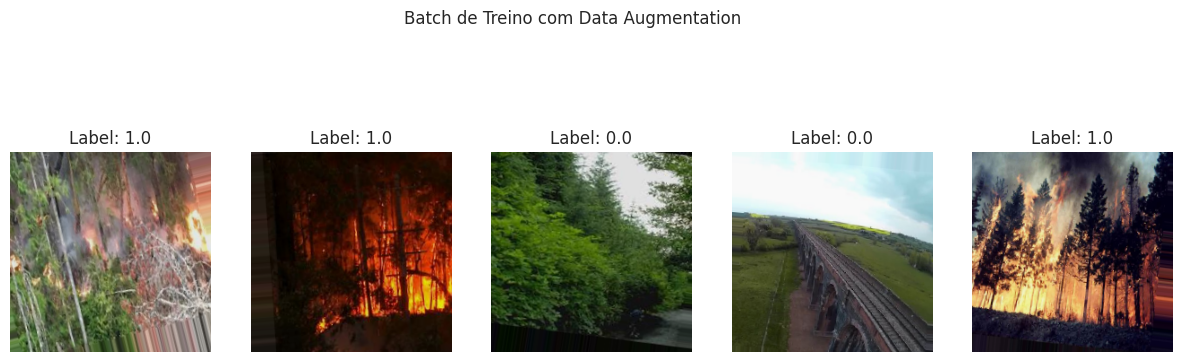

Exemplos de batch de validação:


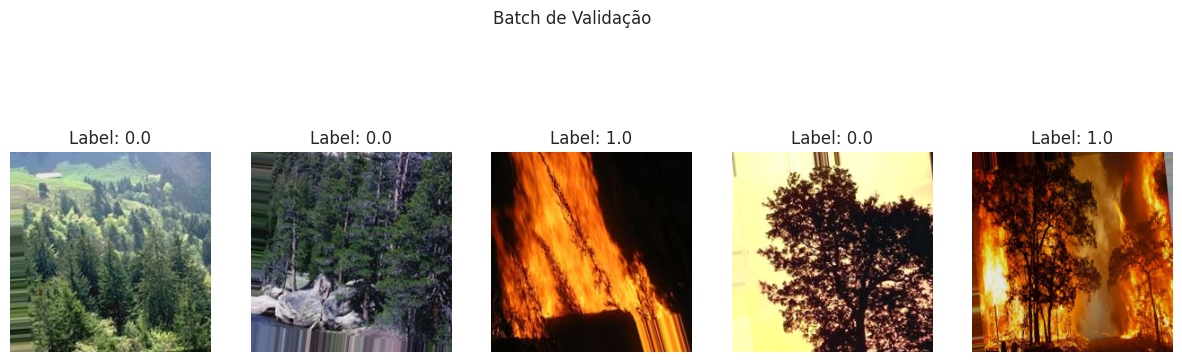

In [26]:
def plot_sample_batch(generator, title):
    images, labels = next(generator)
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(images))):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

print("\nExemplos de batch de treino:")
plot_sample_batch(train_generator, "Batch de Treino com Data Augmentation")

print("Exemplos de batch de validação:")
plot_sample_batch(val_generator, "Batch de Validação")

### Salvando os metadados

In [27]:
import json

metadata = {
    'input_shape': IMG_SIZE + (3,),
    'classes': train_generator.class_indices,
    'train_samples': train_generator.samples,
    'val_samples': val_generator.samples,
    'test_samples': test_generator.samples,
    'class_weights': class_weights,
    'augmentation_params': {
        'rotation_range': 15,
        'width_shift_range': 0.1,
        'brightness_range': [0.9, 1.1]
    }
}

with open(os.path.join(base_dir, 'preprocessing_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)

print("\nMetadados salvos em preprocessing_metadata.json")
print("""
=== Pré-processamento concluído com sucesso! ===
Próximos passos:
1. Treinar modelo com os geradores criados
2. Usar class_weights para balanceamento
3. Monitorar métricas na validação
""")


Metadados salvos em preprocessing_metadata.json

=== Pré-processamento concluído com sucesso! ===
Próximos passos:
1. Treinar modelo com os geradores criados
2. Usar class_weights para balanceamento
3. Monitorar métricas na validação



# 6. Treinamento do Modelo de IA
## Modelo com MobileNetV2 e Keras:

In [29]:
# Criar e treinar o modelo
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=val_generator, epochs=50)
model.save(model_path)

Epoch 1/50
116/116 [==============================] - 60s 508ms/step - loss: 1.9946 - accuracy: 0.9284 - val_loss: 0.9288 - val_accuracy: 0.9599
Epoch 2/50
116/116 [==============================] - 66s 570ms/step - loss: 0.6758 - accuracy: 0.9604 - val_loss: 0.6617 - val_accuracy: 0.9610
Epoch 3/50
116/116 [==============================] - 66s 571ms/step - loss: 0.3268 - accuracy: 0.9667 - val_loss: 0.3525 - val_accuracy: 0.9599
Epoch 4/50
116/116 [==============================] - 65s 560ms/step - loss: 0.1333 - accuracy: 0.9786 - val_loss: 0.2063 - val_accuracy: 0.9642
Epoch 5/50
116/116 [==============================] - 62s 530ms/step - loss: 0.0900 - accuracy: 0.9786 - val_loss: 0.2044 - val_accuracy: 0.9664
Epoch 6/50
116/116 [==============================] - 63s 542ms/step - loss: 0.1056 - accuracy: 0.9748 - val_loss: 0.2243 - val_accuracy: 0.9599
Epoch 7/50
116/116 [==============================] - 72s 622ms/step - loss: 0.0714 - accuracy: 0.9813 - val_loss: 0.1816 - val_ac

### Avaliando modelo com a pasta de Train (Mais dados disponíveis)

2025-04-06 23:14:04.243921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bianca/Identificação de incêndio/venv/lib/python3.10/site-packages/cv2/../../lib64:
2025-04-06 23:14:04.248090: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-06 23:14:04.250051: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gyovanna): /proc/driver/nvidia/version does not exist
2025-04-06 23:14:04.294381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flag

Found 922 images belonging to 2 classes.
29/29 [==============================] - 13s 407ms/step


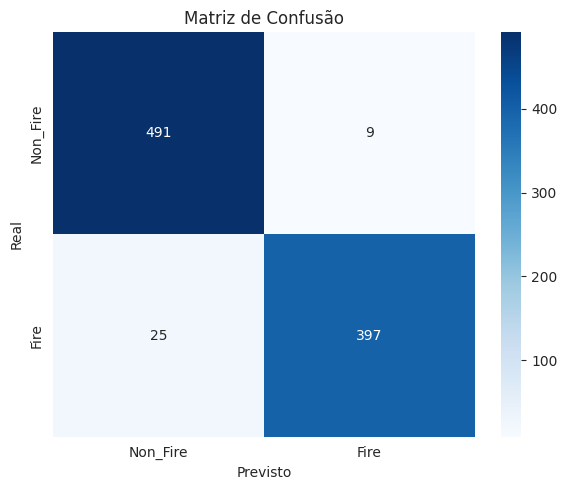


📊 Relatório de Classificação:
              precision    recall  f1-score   support

    Non_Fire       0.95      0.98      0.97       500
        Fire       0.98      0.94      0.96       422

    accuracy                           0.96       922
   macro avg       0.96      0.96      0.96       922
weighted avg       0.96      0.96      0.96       922



In [10]:
# Avaliar o modelo
model = load_model(model_path)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    classes=['Non_Fire', 'Fire'],
    subset="validation",
    shuffle=False
)

predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

print("\n📊 Relatório de Classificação:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

### Avaliando o modelo com o path Test (Apenas 50 imagens | 25 Fire | 25 Non_Fire)

Found 50 images belonging to 2 classes.
2/2 [==============================] - 2s 250ms/step


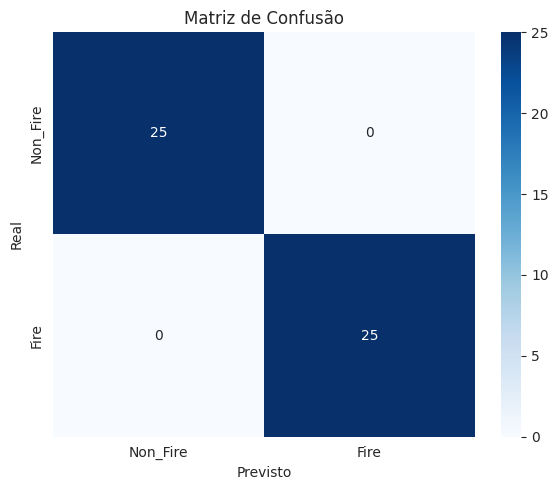


📊 Relatório de Classificação:
              precision    recall  f1-score   support

    Non_Fire       1.00      1.00      1.00        25
        Fire       1.00      1.00      1.00        25

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [11]:
# Carregar modelo
model = load_model(model_path)

# Configurar gerador de teste
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    classes=['Non_Fire','Fire' ],
    shuffle=False
)


# Gerar previsões
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

print("\n📊 Relatório de Classificação:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


In [17]:
# Testar uma imagem manualmente
def prever_imagem(caminho_imagem):
    img = load_img(caminho_imagem, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predicao = model.predict(img_array)
    classe = "✅ Sem incêndio." if predicao[0][0] > 0.5 else "🔥 Incêndio"

    plt.imshow(img)
    plt.title(f"Previsão: {classe} ({predicao[0][0]:.2f})")
    plt.axis("off")
    plt.show()

# 7. Avaliação e Resultados
## Métricas Finais:
### 1 - Test:

In [18]:
test_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    fill_mode='constant', 
)

# Criar dataset aumentado corretamente
augmented_images = []
augmented_labels = []

for i in range(10):  # 10 iterações
    test_generator_aug = test_datagen_aug.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        classes=['Non_Fire', 'Fire'],
        shuffle=False
    )
    
    for images, labels in test_generator_aug:
        augmented_images.extend(images)
        augmented_labels.extend(labels)
        if len(augmented_labels) >= 200:
            break
    if len(augmented_labels) >= 200:
        break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Verificar shapes
print(f"Imagens aumentadas: {augmented_images.shape}")
print(f"Labels aumentados: {augmented_labels.shape}")

# Avaliar
predictions = model.predict(augmented_images)
predicted_classes = (predictions > 0.5).astype(int).flatten()

print("\nRelatório de Classificação (Aumentado):")
print(classification_report(augmented_labels, predicted_classes, target_names=['Non_Fire', 'Fire']))

Found 50 images belonging to 2 classes.


Imagens aumentadas: (200, 224, 224, 3)
Labels aumentados: (200,)
7/7 [==============================] - 2s 233ms/step

Relatório de Classificação (Aumentado):
              precision    recall  f1-score   support

    Non_Fire       0.99      0.90      0.94       100
        Fire       0.91      0.99      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



### 2 - Train

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>precision</th>
      <th>recall</th>
      <th>f1-score</th>
      <th>support</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Fire</th>
      <td>95%</td>
      <td>98%</td>
      <td>97%</td>
      <td>500</td>
    </tr>
    <tr>
      <th>Non_Fire</th>
      <td>98%</td>
      <td>94%</td>
      <td>96%</td>
      <td>422</td>
    </tr>
    <tr>
      <th>accuracy</th>
      <td></td>
      <td></td>
      <td>96%</td>
      <td>922</td>
    </tr>
    <tr>
      <th>macro avg</th>
      <td>96%</td>
      <td>96%</td>
      <td>96%</td>
      <td>922</td>
    </tr>
    <tr>
      <th>weighted avg</th>
      <td>96%</td>
      <td>96%</td>
      <td>96%</td>
      <td>922</td>
    </tr>
  </tbody>
</table>
</div>